In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import RepeatedStratifiedKFold
from datetime import datetime

pd.options.display.max_columns
pd.set_option('display.max_columns', None)

# Data Prep

In [2]:
X_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/X_train.csv', index_col='id')
y_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/y_train.csv', squeeze=True)
X_test = pd.read_csv ('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/test/X_test.csv')

In [3]:
train_df = X_train
train_df['target'] = y_train

In [4]:
train_df['all_priors'] = train_df[[
    'juv_fel_count',
    'juv_misd_count', 
    'juv_other_count',
    'priors_count'
]].sum(axis=1)


### Drop redundant columns

In [5]:

train_df = train_df.drop([
    'name', 'first', 'last',
    'date_of_birth', 'age',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'priors_count'], axis=1)


### Remove cases where c_jail_days are negative. This is bad data

In [6]:
train_df['c_jail_out'] = pd.to_datetime(train_df.c_jail_out)
train_df['c_jail_in'] = pd.to_datetime(train_df.c_jail_in)


train_df['c_jail_days'] = (train_df.c_jail_out - train_df.c_jail_in)
train_df['c_jail_days'] = train_df['c_jail_days'] // np.timedelta64(1, "D")

# remove rows where c_jail_days is null
train_df.dropna(subset=["c_jail_days"], inplace=True)

# drop more date columns
train_df = train_df.drop(["c_jail_out", "c_jail_in", "type_of_assessment", "c_offense_date"], axis=1)


In [7]:
# see if the subject has previously recided
train_df['has_r_jail_in'] = train_df['r_jail_in'].notna()

# check if the are out after receeding
train_df['has_r_jail_out'] = train_df['r_jail_out'].notna()

# drop the r_jail_in and r_jail_out columns 
train_df = train_df.drop(["r_jail_out", "r_jail_in"], axis=1)


In [8]:
# remove v_type of assessment since all occuring values are the same
train_df = train_df.drop(["v_type_of_assessment"], axis=1)

In [9]:
# custody days
train_df.dropna(subset=["target"], inplace=True)

train_df['out_custody'] = pd.to_datetime(train_df.out_custody)
train_df['in_custody'] = pd.to_datetime(train_df.in_custody)

train_df['custody_days'] = (train_df.out_custody - train_df.in_custody)
train_df['custody_days'] = train_df['custody_days'] // np.timedelta64(1, "D")

train_df.dropna(subset=["custody_days"], inplace=True)



In [10]:
train_df = train_df.drop(["screening_date", "v_screening_date"], axis=1)

In [11]:
train_df = train_df.drop(
    ["c_arrest_date", 
    'c_charge_desc', 
    # 'days_b_screening_arrest'
    ], axis=1)
train_df.head()

,sex,age_group,race,days_b_screening_arrest,c_charge_degree,in_custody,out_custody,start,target,all_priors,c_jail_days,has_r_jail_in,has_r_jail_out,custody_days
id,,,,,,,,,,,,,,
2677,Male,Less than 25,Caucasian,-1.0,F,2013-09-23,2013-09-27,3,No-Recidivism,2,3.0,False,False,4
548,Male,Less than 25,African-American,-1.0,F,2013-06-16,2013-06-16,0,No-Recidivism,2,-1.0,False,False,0
56,Female,Less than 25,African-American,-1.0,F,2015-01-30,2015-01-31,79,No-Recidivism,2,79.0,False,False,1
489,Male,25 - 45,Caucasian,0.0,M,2013-10-04,2013-10-05,1,No-Recidivism,2,1.0,False,False,1
430,Male,25 - 45,African-American,-1.0,M,2015-09-03,2015-09-14,1,No-Recidivism,1,1.0,True,True,11


In [12]:
train_df['target_int'] = train_df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 2})
train_df['target_bool'] = train_df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 1})

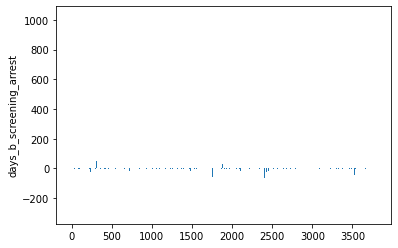

In [43]:
training_features = [
    'sex', 'age_group', 'race', 
    'days_b_screening_arrest',
    'c_charge_degree',
    # 'c_charge_desc',
    'start', 'all_priors',
    'c_jail_days', 'has_r_jail_in', 'has_r_jail_out', 'custody_days'
]

cat_features = ['sex', "age_group", 'race', 'c_charge_degree', 'has_r_jail_in', 'has_r_jail_out']

train_df[training_features].head()

import matplotlib.pyplot as plt

plt.bar(train_df.index, train_df.days_b_screening_arrest)
plt.ylabel('days_b_screening_arrest')
plt.show()


# Model

In [46]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

X_split = train_df
y_split = train_df.race
epoch = 0

for train_idx, val_idx in rskf.split(X_split, y_split):

    X_train = X_split.iloc[train_idx].reset_index(drop=True)
    X_val = X_split.iloc[val_idx].reset_index(drop=True)

    training_set = X_train[training_features]
    training_target = X_train.target_int

    validation_set = X_val[training_features]
    validation_target = X_val.target_int

    # encode dataset
    encoder = ColumnTransformer(
        [("OneHotEncoder", OneHotEncoder(), cat_features)],
        remainder='passthrough'
    ).fit(training_set)
    
    training_set = encoder.transform(training_set)
    validation_set = encoder.transform(validation_set)

#     normalize dataset
    normalizer = Normalizer().fit(training_set)
    
    training_set = normalizer.transform(training_set)
    validation_set = normalizer.transform(validation_set)

    # fit model
#     model = OneVsOneClassifier(
    model = LogisticRegressionCV(random_state=0, max_iter=1000)
        # LinearSVC(random_state=0, max_iter=10000)
#     )
    
    model.fit(training_set, training_target)

    prediction = model.predict(validation_set)
    prediction_proba = model.predict_proba(validation_set)
#     decision_func = model.decision_function(validation_set)
    score = model.score(training_set, training_target)
    roc = roc_auc_score(validation_target, prediction_proba, multi_class="ovo")
    

    epoch += 1
    print(f"epoch: {epoch} - score: {score:.4f} - roc: {roc:.4f}")

print(np.round(prediction_proba, decimals=4))

epoch: 1 - score: 0.7915 - roc: 0.5587
epoch: 2 - score: 0.8004 - roc: 0.5226
epoch: 3 - score: 0.7935 - roc: 0.4397
epoch: 4 - score: 0.7895 - roc: 0.4475
epoch: 5 - score: 0.7974 - roc: 0.5452
epoch: 6 - score: 0.7895 - roc: 0.4980
epoch: 7 - score: 0.8004 - roc: 0.5183
epoch: 8 - score: 0.7945 - roc: 0.4512
epoch: 9 - score: 0.7935 - roc: 0.5100
epoch: 10 - score: 0.7945 - roc: 0.5101
epoch: 11 - score: 0.8113 - roc: 0.5201
epoch: 12 - score: 0.7836 - roc: 0.4765
epoch: 13 - score: 0.7925 - roc: 0.4986
epoch: 14 - score: 0.7935 - roc: 0.4872
epoch: 15 - score: 0.7915 - roc: 0.4915
epoch: 16 - score: 0.7964 - roc: 0.4753
epoch: 17 - score: 0.7866 - roc: 0.4727
epoch: 18 - score: 0.7945 - roc: 0.4984
epoch: 19 - score: 0.7974 - roc: 0.5512
epoch: 20 - score: 0.7974 - roc: 0.5462
epoch: 21 - score: 0.7974 - roc: 0.5075
epoch: 22 - score: 0.7915 - roc: 0.5656
epoch: 23 - score: 0.7875 - roc: 0.4057
epoch: 24 - score: 0.7905 - roc: 0.4802
epoch: 25 - score: 0.8053 - roc: 0.5088
epoch: 26

In [ ]:
roc_race = {}

races = []
race_validation_set = validation_set[[]]